In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX

from commons import DATA_PATH
from ts_modelling import backward_modelling

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

from sklearn.preprocessing import MinMaxScaler

/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_5707/621614190.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Seasonal decomposition of biweekly data project 
- The BeanUtils case

In [4]:
# Obtain the data from the path
project_name = "httpcore"
data_path = os.path.join(DATA_PATH, "biweekly_data", f"{project_name}.csv")
data_df = pd.read_csv(data_path)
data_df.head()

,COMMIT_DATE,SQALE_INDEX,S1213,RedundantThrowsDeclarationCheck,S00117,S00122,S1488,S1905,UselessImportCheck,DuplicatedBlocks,S1226,S00112,S1155,S00108,S1151,S1132,S1481
0,2005-02-19 18:15:52,547.0,50.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,2005-03-05 22:20:39,2033.0,48.0,0.0,0.0,6.0,0.0,0.0,1.0,3.0,0.0,2.0,2.0,3.0,0.0,2.0,4.0
2,2005-03-23 22:12:38,2816.0,48.0,0.0,0.0,6.0,0.0,0.0,1.0,5.0,0.0,5.0,2.0,3.0,0.0,5.0,7.0
3,2005-04-07 19:52:19,10225.0,70.0,7.0,0.0,9.0,0.0,2.0,2.0,13.0,5.0,23.0,2.0,5.0,3.0,7.0,32.0
4,2005-04-24 21:31:41,11502.0,69.0,7.0,0.0,9.0,0.0,2.0,3.0,18.0,5.0,23.0,2.0,5.0,3.0,7.0,32.0


In [8]:
# Due to design reasons in matplotlib, we need to set the global font size in for out purposes and then set them bat to the original numbers.
#original_params = mpl.rcParams.copy()

# And then use:
mpl.rcParams.update(original_params)

In [45]:
original_params

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
   

In [6]:
plt.rcParams['axes.labelsize'] = 13  
plt.rcParams['axes.titlesize'] = 14  
plt.rcParams['xtick.labelsize'] = 11  
plt.rcParams['ytick.labelsize'] = 11 

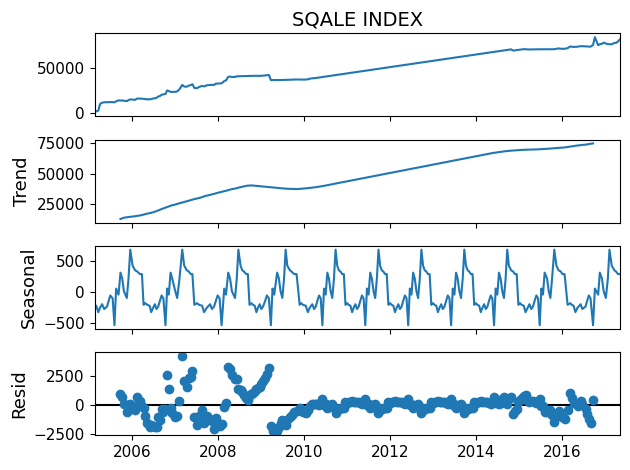

In [7]:
data_df.index = pd.to_datetime(data_df['COMMIT_DATE'])
sqale_index = data_df['SQALE_INDEX']
sqale_index.name = 'SQALE INDEX'
decomposition = sm.tsa.seasonal_decompose(sqale_index,
                                          model='additive',
                                          period=26)
decomposition.plot()
plt.savefig(os.path.join(DATA_PATH, "decomposition.pdf"))
plt.show()

# Providing model diagnostics for biweekly data case
- The httpcore case
- The introduced paramers are the best combination obtained from the described process in the article.

In [4]:
project_name = "httpcore"
periodicity = 'biweekly'
seasonality = 'true'
data_path = os.path.join(DATA_PATH, "biweekly_data", f"{project_name}.csv")
data_df = pd.read_csv(data_path)

In [ ]:
project_name = "httpcore"
periodicity = 'biweekly'
seasonality = 'true'
data_path = os.path.join(DATA_PATH, "biweekly_data", f"{project_name}.csv")
data_df = pd.read_csv(data_path)

sqale_index = data_df.SQALE_INDEX.to_numpy()  # Dependent variable
split_point = round(len(sqale_index)*0.8)  # Initial data splitting. (80% training 20% testing)
training_df = data_df.iloc[:split_point, :]
testing_df = data_df.iloc[split_point:, :]

best_model_params, best_aic, best_regressors = backward_modelling(df=training_df, periodicity=periodicity,
                                                                  seasonality=seasonality)

In [62]:
print(best_model_params, best_aic, best_regressors)

((1, 0, 0), (2, 1, 0, 26)) 24.0 ['RedundantThrowsDeclarationCheck', 'S00117', 'S00122', 'S1488', 'UselessImportCheck', 'S00108', 'S1151', 'S1132']


In [ ]:
# For the sake of not rerunning the previous function again, we store the obtained output
best_regressors = ['RedundantThrowsDeclarationCheck', 'S00117', 'S00122', 'S1488', 'UselessImportCheck', 'S00108', 'S1151', 'S1132']
best_aic = 24
best_model_params = ((1, 0, 0), (2, 1, 0, 26))

In [5]:
X_train = data_df[['RedundantThrowsDeclarationCheck', 'S00117', 'S00122', 'S1488', 'UselessImportCheck', 'S00108', 'S1151', 'S1132']].astype(float)
y_train = data_df['SQALE_INDEX'].astype(float)
X_train_scaled = X_train.map(np.log1p)

# Model fitting
model = SARIMAX(y_train.to_numpy(), exog=X_train_scaled.to_numpy(), order=(1, 0, 0),
                seasonal_order=(2, 1, 0, 26), enforce_stationarity=False, enforce_invertibility=False)
fitted_model = model.fit(disp=0, maxiter=1000)

In [64]:
print(fitted_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  284
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 26)   Log Likelihood               -1794.536
Date:                            Sat, 09 Mar 2024   AIC                           3613.072
Time:                                    11:53:01   BIC                           3652.948
Sample:                                         0   HQIC                          3629.201
                                            - 284                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4598.3430   3344.963      1.375      0.169   -1957.664    1.12e+04
x2          3208.4248   1414.910   

In [53]:
plt.rcParams['axes.labelsize'] = 17  
plt.rcParams['axes.titlesize'] = 17  
plt.rcParams['xtick.labelsize'] = 17  
plt.rcParams['ytick.labelsize'] = 17 
plt.rcParams['legend.fontsize'] = 15

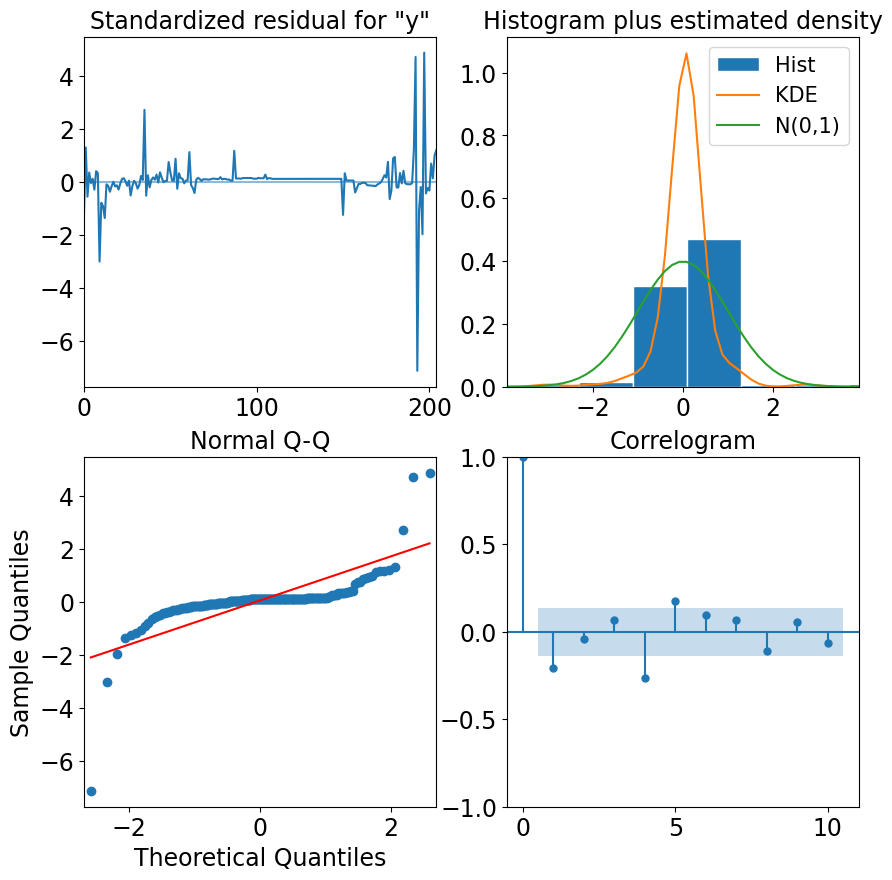

In [54]:
fig = fitted_model.plot_diagnostics(figsize=(10, 10))  # Initial: 8,7
plt.savefig(os.path.join(DATA_PATH, 'model-diagnostics.pdf'), format='pdf')
plt.show()

# Generating results output (Barplots)

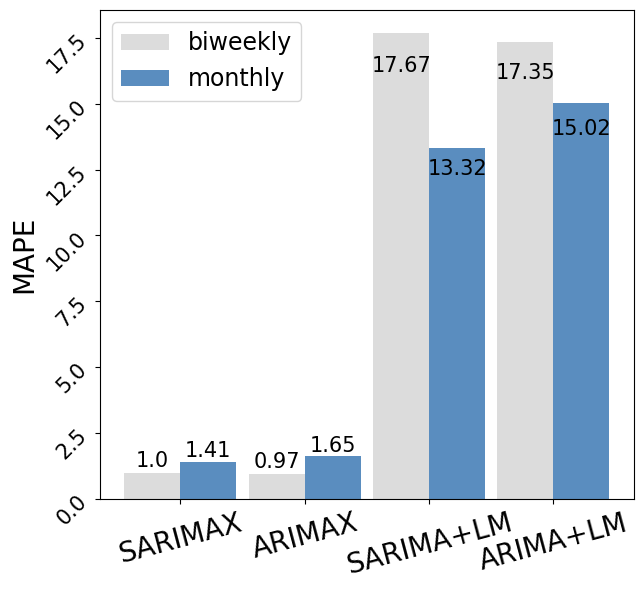

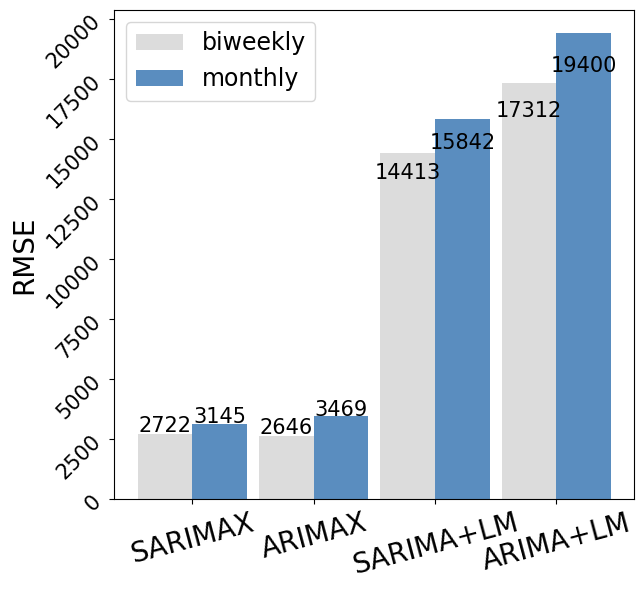

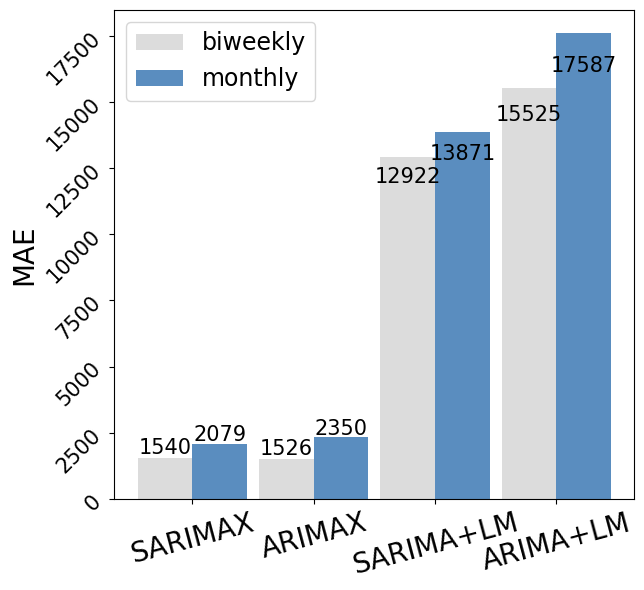

In [32]:
values_list = ['SARIMAX', 'ARIMAX', 'SARIMA+LM', 'ARIMA+LM']  # TS models to be compared towards the seasonality factor
metrics_list = ['MAPE' ,'RMSE', 'MAE']
models_list = ['sarimax_results', 'arimax_results', 'sarima_lm_results', 'arima_lm_results']

# Data sources
biweekly_results_df = pd.read_csv(os.path.join(DATA_PATH, 'final_results', 'biweekly_data_results.csv')).set_index('Approach')
biweekly_results_df = biweekly_results_df.rename(index={'sarimax_results': 'SARIMAX', 'arimax_results': 'ARIMAX', 'sarima_lm_results': 'SARIMA+LM', 'arima_lm_results': 'ARIMA+LM'})

monthly_results_df = pd.read_csv(os.path.join(DATA_PATH, 'final_results', 'monthly_data_results.csv')).set_index('Approach')
monthly_results_df = monthly_results_df.rename(index={'sarimax_results': 'SARIMAX', 'arimax_results': 'ARIMAX', 'sarima_lm_results': 'SARIMA+LM', 'arima_lm_results': 'ARIMA+LM'})


# Function to auto-label the bars, if desired
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        five_percent = height*0.1
        #print(f"height: {height}")
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height-five_percent),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=15)
# plt.rcParams["figure.figsize"] = (6.4, 6)
for i in range(len(metrics_list)):

    biweekly_results = biweekly_results_df.loc[values_list, metrics_list[i]]
    monthly_results = monthly_results_df.loc[values_list, metrics_list[i]]
    plot_data = pd.DataFrame({'biweekly': biweekly_results, 'monthly': monthly_results})
    # Plotting
    fig, ax = plt.subplots()
    x = np.arange(len(values_list))  # the label locations
    width = 0.45  # the width of the bars

    # Creating bars
    if i == 0:
        rects1 = ax.bar(x - width/2, plot_data['biweekly'], width, label='biweekly', color='#DCDCDC')
        rects2 = ax.bar(x + width/2, plot_data['monthly'], width, label='monthly', color='#5A8DBF')    
    else:
        rects1 = ax.bar(x - width/2, plot_data['biweekly'].round().astype(int), width, label='biweekly', color='#DCDCDC')
        rects2 = ax.bar(x + width/2, plot_data['monthly'].round().astype(int), width, label='monthly', color='#5A8DBF')

    # Adding some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel(metrics_list[i], fontsize=20)
    ax.set_title('')
    ax.set_xticks(x)
    ax.set_xticklabels(values_list, fontsize=20, rotation=15)
    ax.legend(fontsize=17)

    # Call the function to label bars
    autolabel(rects1)
    autolabel(rects2)
    plt.tight_layout()
    plt.yticks(fontsize=15, rotation=45)
    plt.savefig(os.path.join(DATA_PATH, f'{metrics_list[i]}.pdf'), format='pdf')
    plt.show()


# Viasualization of TS vs ML models (radar charts)
- Using built-in codes from matplotlib [Radar chart](https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html)

In [120]:
def scaled_data(models, metrics):
    """
    Scales the considered columns from the existing data
    """
    
    
    scaler = MinMaxScaler()
    # Make just one test with MAPE and biweekly data, and then check if it's useful or even understandable.
    biweekly_results_path = os.path.join(DATA_PATH, 'final_results', 'biweekly_data_results.csv')
    biweekly_results_df = pd.read_csv(biweekly_results_path).set_index('Approach')
    biweekly_metrics_df = biweekly_results_df.loc[models, metrics]
    scaled_metrics_df = scaler.fit_transform(biweekly_metrics_df.to_numpy())
    scaled_metrics_df = (pd.DataFrame(scaled_metrics_df, columns=metrics, index=models)
                         .rename(index={'sarimax_results': "SARIMAX", 'sarima_lm_results': 'SARIMA+LM'}))

    scaled_metrics_dict = scaled_metrics_df.to_dict(orient='split')
    
    return scaled_metrics_dict

In [115]:
data = scaled_data(models=models_list, metrics=metrics_list)

{'index': ['SARIMAX', 'SARIMA+LM', 'mlr', 'L1', 'L2', 'sgd', 'xgb', 'rf', 'svr'], 'columns': ['MAPE', 'MAE', 'RMSE'], 'data': [[0.0, 0.0, 0.0], [0.7289024923480543, 0.3044169581064846, 0.3144215235107138], [0.1683428071709663, 0.08974759475226454, 0.10858575331722715], [0.18277219064276343, 0.1040742377186066, 0.11806900090661147], [0.16878006121556627, 0.08983050666130324, 0.10725125133093848], [0.17665063401836467, 0.10575815184540513, 0.12245306315540062], [0.031482291211193704, 0.039229101117224593, 0.05283681181504911], [0.019239177962396152, 0.01879292028581607, 0.031113905741989287], [1.0, 0.9999999999999999, 0.9999999999999999]]}


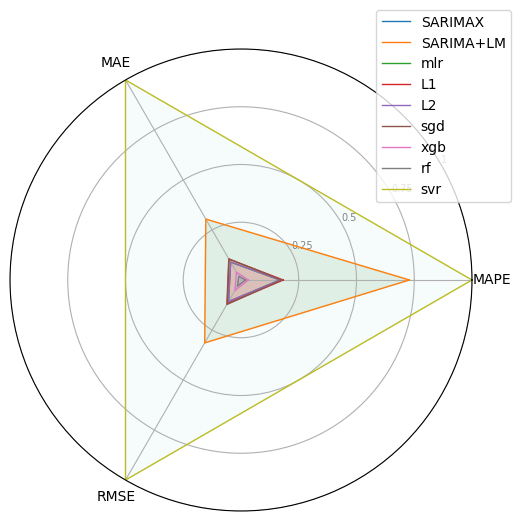

In [190]:
metrics_list = ['MAPE', 'MAE', 'RMSE']
models_list = ['sarimax_results', 'sarima_lm_results', 'mlr', 'L1', 'L2', 'sgd', 'xgb', 'rf', 'svr']
colors = ['blue', 'green', 'red', 'orange', 'purple', 'pink', 'cyan', 'magenta', 'lightblue']
data = scaled_data(models=models_list, metrics=metrics_list)

# Angles of the three metrics within the radar
angles = np.linspace(0, 2 * np.pi, len(metrics_list), endpoint=False).tolist()

# Complete the loop for each of the triangles that the models will form
for i in range(len(models_list)):
    data['data'][i] += data['data'][i][:1]

angles += angles[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

# Axes and metric names
plt.xticks(angles[:-1], metrics_list)

# Draw the labels
ax.set_rlabel_position(30)
plt.yticks([0.25, 0.50, 0.75, 1], ['0.25', '0.5', '0.75', '1'], color='grey', size=7)
plt.ylim(0,1)

# PLot each model's triangle
for i in range(len(models_list)):
    ax.plot(angles, data['data'][i], linewidth=1, linestyle='solid', label=data['index'][i])
    ax.fill(angles, data['data'][i], color=colors[i], alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

# Second approah with radar chart

In [125]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [199]:
def order_data(models, metrics):
    """
    Scales the considered columns from the existing data
    """
    
    final_output = [models]
    scaler = MinMaxScaler()
    # Make just one test with MAPE and biweekly data, and then check if it's useful or even understandable.
    biweekly_results_path = os.path.join(DATA_PATH, 'final_results', 'biweekly_data_results.csv')
    biweekly_results_df = pd.read_csv(biweekly_results_path).set_index('Approach')
    biweekly_metrics_df = biweekly_results_df.loc[models, metrics]
    scaled_metrics_df = scaler.fit_transform(biweekly_metrics_df.to_numpy())
    scaled_metrics_df = (pd.DataFrame(scaled_metrics_df, columns=metrics, index=models)
                         .rename(index={'sarimax_results': "SARIMAX", 'sarima_lm_results': 'SARIMA+LM'}))
    for i in range(len(metrics)):
        metrics_vals = (metrics[i], scaled_metrics_df[metrics[i]].tolist())
        final_output.append(metrics_vals)
    
    return final_output

In [203]:
order_data(models=models_list, metrics=metrics_list)

[['sarimax_results',
  'sarima_lm_results',
  'mlr',
  'L1',
  'L2',
  'sgd',
  'xgb',
  'rf',
  'svr'],
 ('MAPE',
  [0.0,
   0.7289024923480543,
   0.1683428071709663,
   0.18277219064276343,
   0.16878006121556627,
   0.17665063401836467,
   0.031482291211193704,
   0.019239177962396152,
   1.0]),
 ('MAE',
  [0.0,
   0.3044169581064846,
   0.08974759475226454,
   0.1040742377186066,
   0.08983050666130324,
   0.10575815184540513,
   0.039229101117224593,
   0.01879292028581607,
   0.9999999999999999]),
 ('RMSE',
  [0.0,
   0.3144215235107138,
   0.10858575331722715,
   0.11806900090661147,
   0.10725125133093848,
   0.12245306315540062,
   0.05283681181504911,
   0.031113905741989287,
   0.9999999999999999])]

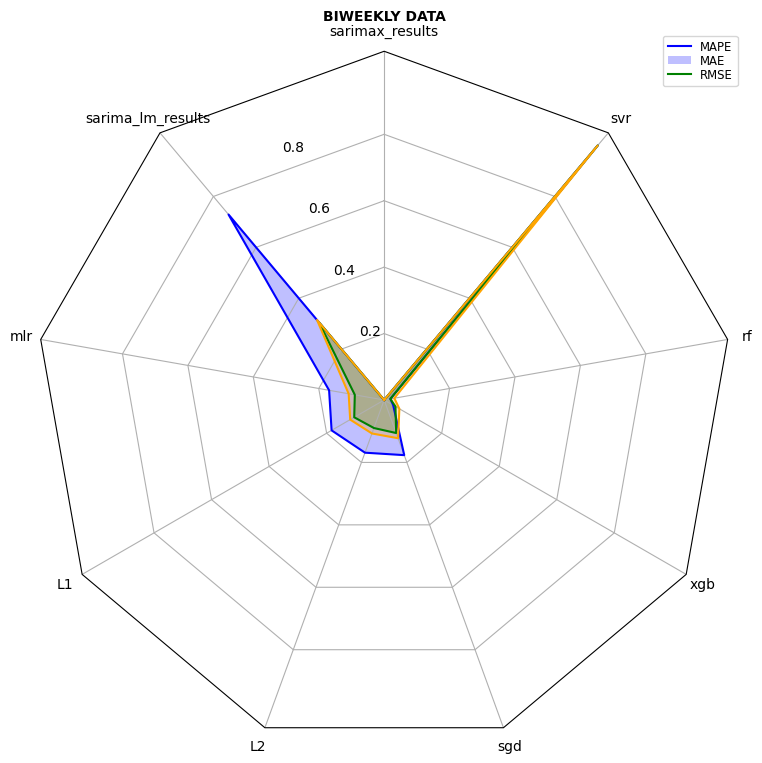

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon, Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from matplotlib.projections import register_projection

# Assuming radar_factory is as you defined
# Assuming order_data function is properly defined elsewhere

models_list = ['sarimax_results', 'sarima_lm_results', 'mlr', 'L1', 'L2', 'sgd', 'xgb', 'rf', 'svr']
metrics_list = ['MAPE', 'MAE', 'RMSE']
data = [['sarimax_results', 'sarima_lm_results', 'mlr', 'L1', 'L2', 'sgd', 'xgb', 'rf', 'svr'],
        ('MAPE', [0.0, 0.7289024923480543, 0.1683428071709663, 0.18277219064276343, 0.16878006121556627, 0.17665063401836467, 0.031482291211193704, 0.019239177962396152, 1.0]),
        ('MAE', [0.0, 0.3044169581064846, 0.08974759475226454, 0.1040742377186066, 0.08983050666130324, 0.10575815184540513, 0.039229101117224593, 0.01879292028581607, 0.9999999999999999]),
        ('RMSE', [0.0, 0.3144215235107138, 0.10858575331722715, 0.11806900090661147, 0.10725125133093848, 0.12245306315540062, 0.05283681181504911, 0.031113905741989287, 0.9999999999999999])]

N = 9
theta = radar_factory(N, frame='polygon')

spoke_labels = data.pop(0)

fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                       subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.40, top=0.85, bottom=0.05)

colors = ['blue', 'green', 'orange']

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_title('BIWEEKLY DATA', weight='bold', size='medium', position=(0.5, 1.1),
             horizontalalignment='center', verticalalignment='center')
for (metric_name, d), color in zip(data, colors):
    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.25)
ax.set_varlabels(spoke_labels)

legend = ax.legend(metrics_list, loc=(0.9, .95),
                   labelspacing=0.1, fontsize='small')

plt.show()


# Visualization of TS vs ML models (bar charts)

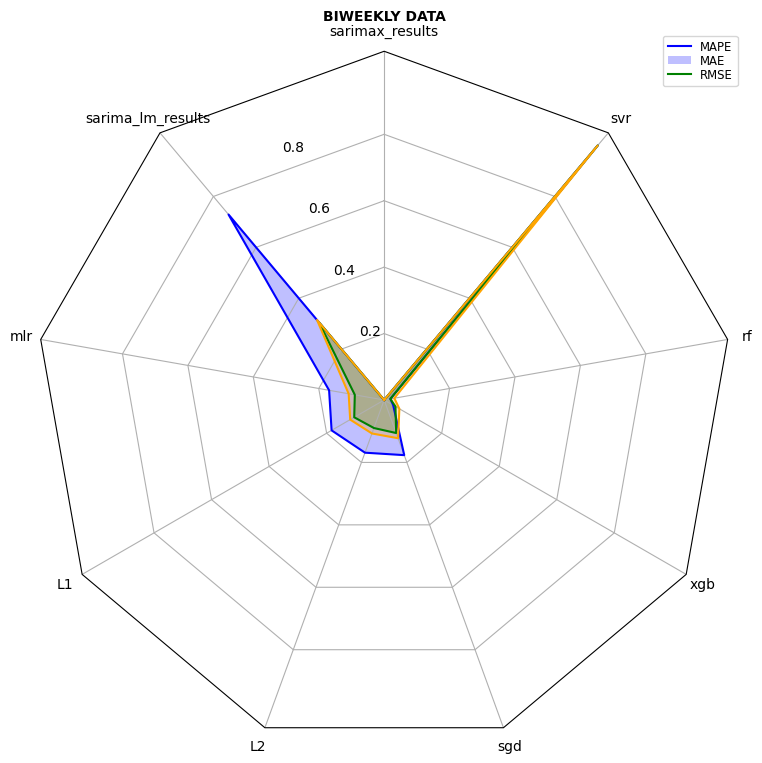

In [204]:
fig, ax1 = plt.subplots(figsize=(9, 9))


# Barplots for the SARIMAX vs ML models

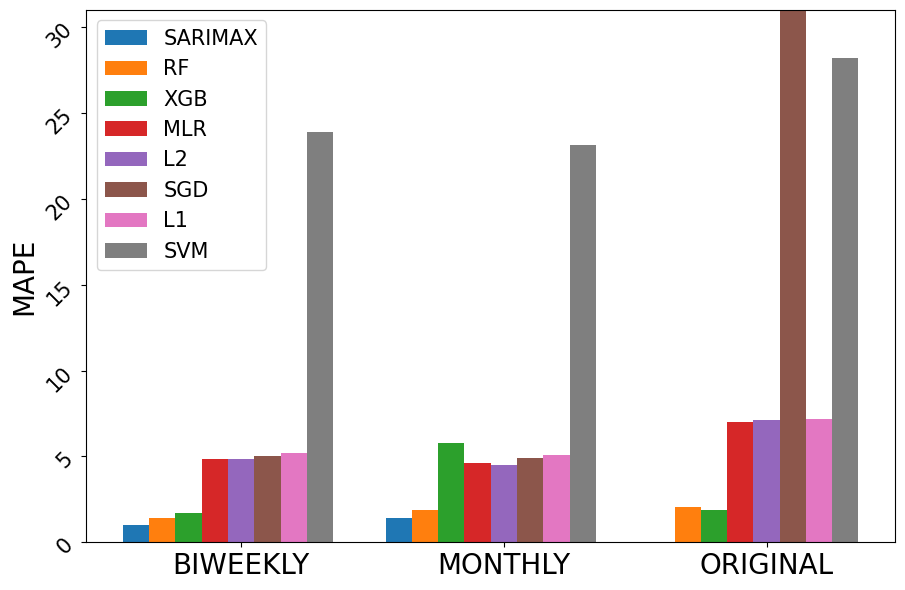

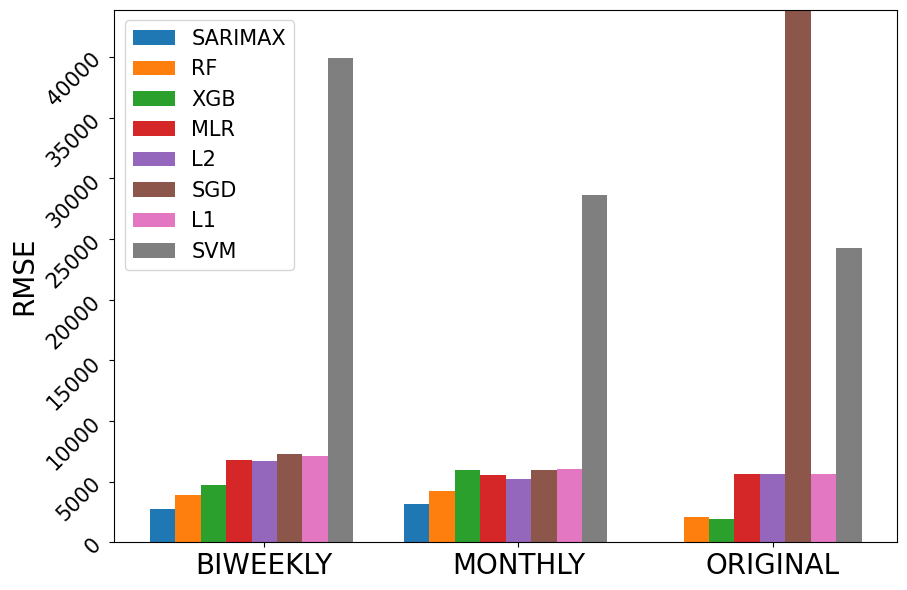

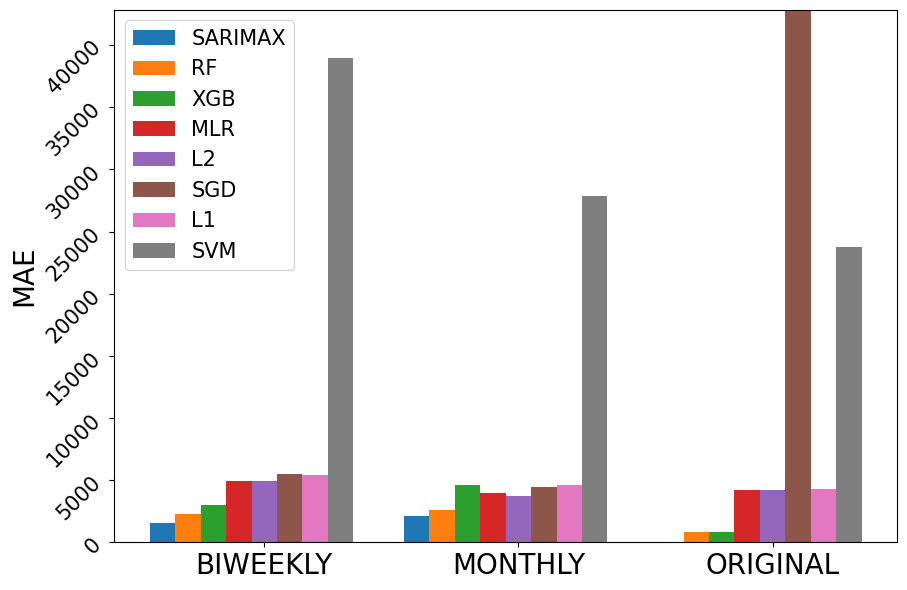

In [86]:
values_list = ['SARIMAX', 'RF', 'XGB', 'MLR', 'L2', 'SGD', 'L1', 'SVM']  # TS models to be compared towards the seasonality factor
metrics_list = ['MAPE' ,'RMSE', 'MAE']
periods_list = ['BIWEEKLY', 'MONTHLY', 'ORIGINAL']
models_list = ['sarimax_results', 'rf', 'xgb', 'mlr', 'L2', 'sgd', 'L1', 'svr']
df_list = []

# Data sources
biweekly_results_df = pd.read_csv(os.path.join(DATA_PATH, 'final_results', 'biweekly_data_results.csv')).set_index('Approach')
biweekly_results_df = biweekly_results_df.rename(index={'sarimax_results': 'SARIMAX', 'rf': 'RF', 'xgb': 'XGB', 'mlr': 'MLR', 'svr':'SVM', 'sgd': 'SGD'})
df_list.append(biweekly_results_df)

monthly_results_df = pd.read_csv(os.path.join(DATA_PATH, 'final_results', 'monthly_data_results.csv')).set_index('Approach')
monthly_results_df = monthly_results_df.rename(index={'sarimax_results': 'SARIMAX', 'rf': 'RF', 'xgb': 'XGB', 'mlr': 'MLR', 'svr':'SVM', 'sgd': 'SGD'})
df_list.append(monthly_results_df)

complete_results_df = pd.read_csv(os.path.join(DATA_PATH, 'final_results', 'complete_data_results.csv')).set_index('Approach')
complete_results_df = complete_results_df.rename(index={'rf': 'RF', 'xgb': 'XGB', 'mlr': 'MLR', 'svr':'SVM', 'sgd': 'SGD'})
df_list.append(complete_results_df)

# Quicksort algorithm to sort the complete list of results for one metric
def qsort(inlist):

    if inlist == []:
        return []
    else:
        pivot = inlist[0]
        lesser = qsort([x for x in inlist[1:] if x < pivot])
        greater = qsort([x for x in inlist[1:] if x >= pivot])
        return lesser + [pivot] + greater


def get_ylimit(metric, df_list):
    """
    Sets the correct limit for the given results in order to plot them diligently
    :param metric: Name of the metrics whose values are being considered 
    """
    results_list = []
    # First we go over all the results for the given metric
    for i in range(len(df_list)):  # Dataframes based on the data type
        results_df = df_list[i]
        column_vals = results_df[metric]
        for j in range(len(column_vals)):  # Columns of each df based on the model name
            
            # If the data we are handling is the original one, we skip the first model as there is no sarimax results for the original data    
            results_list.append(column_vals.iloc[j])
    
    sorted_list = qsort(results_list)
    # Get the upper limit of the y axis to be 10% higher than the value of the second biggest result
    return int(sorted_list[-2] + sorted_list[-2]*0.10)

for z in range(len(metrics_list)):
    results_dict = {period:[] for period in periods_list}
    for i in range(len(periods_list)):
        # Goes appending the models into the dict format
        for j in range(len(models_list)):
            
            # FOr the original data there is no registered value for SARIMAX
            if periods_list[i] == 'ORIGINAL' and j == 0:
                results_dict[periods_list[i]].append(0)
            # Considers the periodicity level as the key of the dict and then appends the value of each model for that periodicity model.
            else:
                results_dict[periods_list[i]].append(df_list[i].loc[values_list[j], metrics_list[z]])
    
    
    # Set up the bar width and initial position
    bar_width = 0.1
    initial_r = np.arange(len(periods_list))
    
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(9, 6))
    
    # Generate bars for each model
    for idx, model in enumerate(values_list):
        r = [x + (bar_width * idx) for x in initial_r]
        mape_scores = [results_dict[dt][idx] for dt in periods_list]
        ax.bar(r, mape_scores, width=bar_width, label=model)
    
    # Add xticks on the middle of the group bars
    ax.set_xticks([r + bar_width*(len(values_list)/2) for r in range(len(periods_list))])
    ax.set_xticklabels(periods_list, fontsize=20)
    y_max_limit = get_ylimit(metric=metrics_list[z], df_list=df_list)
    ax.set_ylim([0,y_max_limit])
    
    # Set axis labels and title
    #ax.set_xlabel('Periodicity levels', fontweight='bold')
    ax.set_ylabel(metrics_list[z], fontsize=20)
    ax.set_title('')
    
    # Create legend
    ax.legend(fontsize=15)
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.yticks(fontsize=15, rotation=45)
    plt.savefig(os.path.join(DATA_PATH, f'ML-{metrics_list[z]}.pdf'), format='pdf')
    plt.show()